In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model
import quantstats

pd.set_option('display.float_format', '{:.2f}'.format)


# dataframe

In [22]:
df = yfin.download('^TWII', start = '2019-9-1', end = '2024-5-30')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']


[*********************100%%**********************]  1 of 1 completed


# function

In [23]:
def get_llt(df, a):
    llt = np.zeros(len(df))
    llt[0] = df['close'].iloc[0]
    llt[1] = (1 - a) * df['close'].iloc[0] + a * df['close'].iloc[1]
    for n in range(2, len(df)):
        llt[n] = ((a - (a ** 2)/4) * df['close'].iloc[n]) + (((a ** 2)/2) * df['close'].iloc[n - 1]) - ((a - (3 * (a ** 2))/4) * df['close'].iloc[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    
    df['llt'] = llt
    df['llt_slope'] = np.nan

    for i in range(0, len(df)):
        df.loc[df.index[i], 'llt_slope'] = df['llt'].iloc[i] - df['llt'].iloc[i - 1]
    return df


def get_bolinger_band(df, p, q, rolling, num_vol, distance_threshold, retrace_threshold):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = p, q = q, rescale = False)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    df['bolinger_upper_smooth'] = df['bolinger_upper'].ewm(span = rolling).mean()
    df['bolinger_lower_smooth'] = df['bolinger_lower'].ewm(span = rolling).mean()

    df = get_middle(df)

    df['upper_max'] = df['bolinger_upper'].rolling(window = rolling).max()
    df['lower_min'] = df['bolinger_lower'].rolling(window = rolling).min()

    df['upper_retrace'] = (df['upper_max'] - df['bolinger_upper']) / df['upper_max']
    df['lower_retrace'] = (df['bolinger_lower'] - df['lower_min']) / df['lower_min']

    df['upper_deviation'] = abs(df['bolinger_upper'] - df['middle']) / df['middle']
    df['lower_deviation'] = abs(df['middle'] - df['bolinger_lower']) / df['middle']

    df['upper_rise'] = df['upper_deviation'] >= distance_threshold
    df['lower_down'] = df['lower_deviation'] >= distance_threshold
    df['upper_down'] = df['upper_retrace'] >= retrace_threshold
    df['lower_rise'] = df['lower_retrace'] >= retrace_threshold

    return df

def get_middle(df):
    df['peak'] = np.nan
    df['upper_change'] = np.nan
    df['lower_change'] = np.nan
    df['middle'] = np.nan

    for i in range(len(df)):
        df.loc[df.index[i], 'upper_change'] = abs(df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1])
        df.loc[df.index[i], 'lower_change'] = abs(df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1])
        
    df['peak'] = df['upper_change'] > df['lower_change']

    df['middle'] = np.where(df['peak'], df['bolinger_lower_smooth'], df['bolinger_upper_smooth'])

    df['middle'] = df['middle'].rolling(window = 50, min_periods = 1).mean()
        
    return df



In [24]:
df.to_csv('df.csv')

# strategy

## long & short


In [25]:
def llt_strategy(df, feePaid, a, p, q, num_vol, rolling, distance_threshold, retrace_threshold):
    
    equity = pd.DataFrame(index = df.index)

    df = get_llt(df, a)
    df = get_bolinger_band(
        df = df, p = p, q = q, rolling = rolling, num_vol = num_vol,
        distance_threshold = distance_threshold, retrace_threshold = retrace_threshold)

    BS = None
    t = 0
    df[['Bull', 'Bear']] = False

    df = df.assign(
        position = np.zeros(len(df)),
        buy = np.zeros(len(df)),
        sell = np.zeros(len(df)),
        sellshort = np.zeros(len(df)),
        buytocover = np.zeros(len(df)),
        buy_price = np.zeros(len(df)),
        sell_price = np.zeros(len(df)),
        short_price = np.zeros(len(df)),
        buytocover_price = np.zeros(len(df)),
        buy_time = np.nan,
        sell_time = np.nan,
        sellshort_time = np.nan,
        buytocover_time = np.nan,
        hold_duration = np.nan,
        profit_list = np.zeros(len(df)),
        profit_fee_list = np.zeros(len(df)),
        profit_fee_list_realized = np.zeros(len(df))
    )
    
    df[['buy_time', 'sell_time', 'sellshort_time', 'buytocover_time']] = df[['buy_time', 'sell_time', 'sellshort_time', 'buytocover_time']].apply(pd.to_datetime, errors='coerce')
    
    for i in range(2, len(df) - 1):
        
        condition1 = abs(df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) > abs(df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
        condition2 = abs(df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) < abs(df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
        condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
        condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
        condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
        condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下
        
        entryLong = (df['llt_slope'].iloc[i] > 0) & (((df['upper_rise'].iloc[i] == True) & condition1) | ((df['lower_rise'].iloc[i] == True) & condition2))
        exitLong = (df['llt_slope'] < 0)
        entryShort = (df['llt_slope'].iloc[i] < 0) & (((df['upper_down'].iloc[i] == True) & condition1) | ((df['lower_down'].iloc[i] == True) & condition2))
        exitShort = (df['llt_slope'] > 0)
        
        df.at[df.index[i], 'Bull'] = (condition1 & condition3) | (condition2 & condition5)
        df.at[df.index[i], 'Bear'] = (condition1 & condition4) | (condition2 & condition6)

        if BS == None:
            if df['Bull'].iloc[i]:
                if entryLong:
                    BS = 'B'
                    t = i + 1
                    df.at[df.index[t], 'buy'] = t
                    df.at[df.index[t], 'buy_price'] = df['open'].iloc[t]
                    df.at[df.index[t], 'buy_time'] = df.index[t]
                    df.at[df.index[t], 'position'] += 1

            elif df['Bear'].iloc[i]:
                if entryShort:
                    BS = 'S'
                    t = i + 1
                    df.at[df.index[t], 'sellshort'] = t
                    df.at[df.index[t], 'short_price'] = df['open'].iloc[t]
                    df.at[df.index[t], 'sellshort_time'] = df.index[t]
                    df.at[df.index[t], 'position'] -= 1

        elif BS == 'B':
                
            df.at[df.index[i + 1], 'position'] = df.at[df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * df['position'].iloc[i + 1]
            df.at[df.index[i], 'profit_list'] = profit

            if exitLong:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                df.at[df.index[i + 1], 'position'] -= 1
                df.at[df.index[i], 'profit_fee_list'] = profit_fee
                df.at[df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                df.at[df.index[i + 1], 'sell_time'] = df.index[i + 1]
                df.at[df.index[i + 1], 'hold_duration'] = pd.date_range(start = df.index[t], end = df.index[i], freq = 'B').size
                df.at[df.index[i + 1], 'sell'] = i + 1
                BS = None

                df.at[df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

            elif i == len(df) - 2:
                if df['position'].iloc[len(df) - 2] != 0:
                    unit = df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * df['position'].iloc[i]
                    df.at[df.index[i + 1], 'position'] -= unit
                    df.at[df.index[i], 'profit_fee_list'] = profit_fee
                    df.at[df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    df.at[df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    df.at[df.index[i + 1], 'hold_duration'] = pd.date_range(start = df.index[t], end = df.index[i], freq = 'B').size
                    df.at[df.index[i + 1], 'sell'] = i + 1
                    BS = None

            else:
                profit_fee = profit
                df.at[df.index[i], 'profit_fee_list'] = profit_fee

        elif BS == 'S':
            
            df.at[df.index[i + 1], 'position'] = df.at[df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * df['position'].iloc[i + 1]
            df.at[df.index[i], 'profit_list'] = profit

            if exitShort:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                df.at[df.index[i + 1], 'position'] += 1
                df.at[df.index[i], 'profit_fee_list'] = profit_fee
                df.at[df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                df.at[df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                df.at[df.index[i + 1], 'hold_duration'] = pd.date_range(start = df.index[t], end = df.index[i], freq = 'B').size
                df.at[df.index[i + 1], 'buytocover'] = i + 1
                BS = None

                profit_fee_realized = pl_round - feePaid * 2
                df.at[df.index[i + 1], 'profit_fee_list_realized'] = profit_fee_realized

            elif i == len(df) - 2:
                if df['position'].iloc[len(df) - 2] != 0:
                    unit = df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * df['position'].iloc[i]
                    df.at[df.index[i + 1], 'position'] += unit
                    df.at[df.index[i], 'profit_fee_list'] = profit_fee
                    df.at[df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    df.at[df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    df.at[df.index[i + 1], 'hold_duration'] = pd.date_range(start = df.index[t], end = df.index[i], freq = 'B').size
                    df.at[df.index[i + 1], 'buytocover'] = i + 1
                    BS = None
            else:
                profit_fee = profit
                df.at[df.index[i], 'profit_fee_list'] = profit_fee

        else:
            print('error')
                
    df['strategy_ret'] = df['profit_list'].cumsum()
    equity['profitfee'] = df['profit_fee_list'].cumsum()

    return df, equity

# parametors

In [26]:
a = 0.5
p = 1
q = 1
num_vol = 1
rolling = 10
distance_threshold = 0.04
retrace_threshold = 0.07
fund = 1000000
feePaid = 600

In [27]:

df, equity = llt_strategy(
df, feePaid = feePaid, a = a, p = p, q = q, num_vol = num_vol, rolling = rolling,
distance_threshold = distance_threshold, retrace_threshold = retrace_threshold
)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## 指數

In [ ]:
df['index_ret'] = np.zeros(len(df))

for i in range(1, len(df)):
    df.loc[df.index[i], 'index_ret'] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200

df['cum_index_ret'] = df['index_ret'].cumsum()

## Total performance

In [ ]:
bull_df, bear_df = df[df['Bull'] == True], df[df['Bear'] == True]
bull_equity, bear_equity = pd.DataFrame(index = bull_df.index), pd.DataFrame(index = bear_df.index)
bull_equity['profitfee'], bear_equity['profitfee'] = bull_df['profit_fee_list'].cumsum(), bear_df['profit_fee_list'].cumsum()

In [ ]:
def get_performance(df, equity):
    duration = (equity.index[-1] - equity.index[0]).days
    risk_free_rate = 0.04/252
    equity['equity'] = equity['profitfee'] + fund
    equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
    profit = equity['profitfee'].iloc[-1]
    ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
    mdd = abs(equity['drawdown_percent'].min())
    calmarRatio = ret / mdd
    tradeTimes = min((df['buy'] > 0).sum(), (df['sell'] > 0).sum()) + min((df['sellshort'] > 0).sum(), (df['buytocover'] > 0).sum())
    average_holding_duration = df['hold_duration'].sum() / tradeTimes
    winRate = len([i for i in df['profit_fee_list_realized'] if i > 0]) / tradeTimes
    try:
        profitFactor = sum([i for i in df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in df['profit_fee_list_realized'] if i < 0]))
    except:
        profitFactor = None
    mean_ret = df['profit_list'].mean()
    std_ret = df['profit_list'].std()
    sharp = (mean_ret - risk_free_rate) / std_ret

    print('Duration : ', duration, 'days')
    print('Average holding duration', average_holding_duration, 'days')
    print('Profit : ', profit)
    print('Return : ', ret)
    print('Max DrawDown : ', mdd)
    print('Caimar Ratio : ', calmarRatio)
    print('Trade Times : ', tradeTimes)
    print('Win Rate : ', winRate)
    print('Profit Factor : ', profitFactor)
    print('Sharp Ratio : ', sharp)

print('------------------------------Total----------------------------------')
get_performance(df, equity)
print('------------------------------Bull----------------------------------')
get_performance(bull_df, bull_equity)
print('------------------------------Bear----------------------------------')
get_performance(bear_df, bear_equity)

------------------------------Total----------------------------------
Duration :  1731 days
Average holding duration 5.464566929133858 days
Profit :  1374718.359375
Return :  1.374718359375
Max DrawDown :  0.4768288070783544
Caimar Ratio :  2.8830438492133736
Trade Times :  127
Win Rate :  0.30708661417322836
Profit Factor :  1.5229149818001793
Sharp Ratio :  0.058656781173223094
------------------------------Bull----------------------------------
Duration :  1726 days
Average holding duration 5.846153846153846 days
Profit :  2217835.3515625
Return :  2.2178353515625
Max DrawDown :  0.11589229778193588
Caimar Ratio :  19.1370383883112
Trade Times :  39
Win Rate :  0.3333333333333333
Profit Factor :  1.3540729289433642
Sharp Ratio :  0.14905337153373213
------------------------------Bear----------------------------------
Duration :  1695 days
Average holding duration 10.833333333333334 days
Profit :  -843116.9921875
Return :  -0.8431169921875
Max DrawDown :  0.9745491578567352
Caimar Ra

# plot

## profit

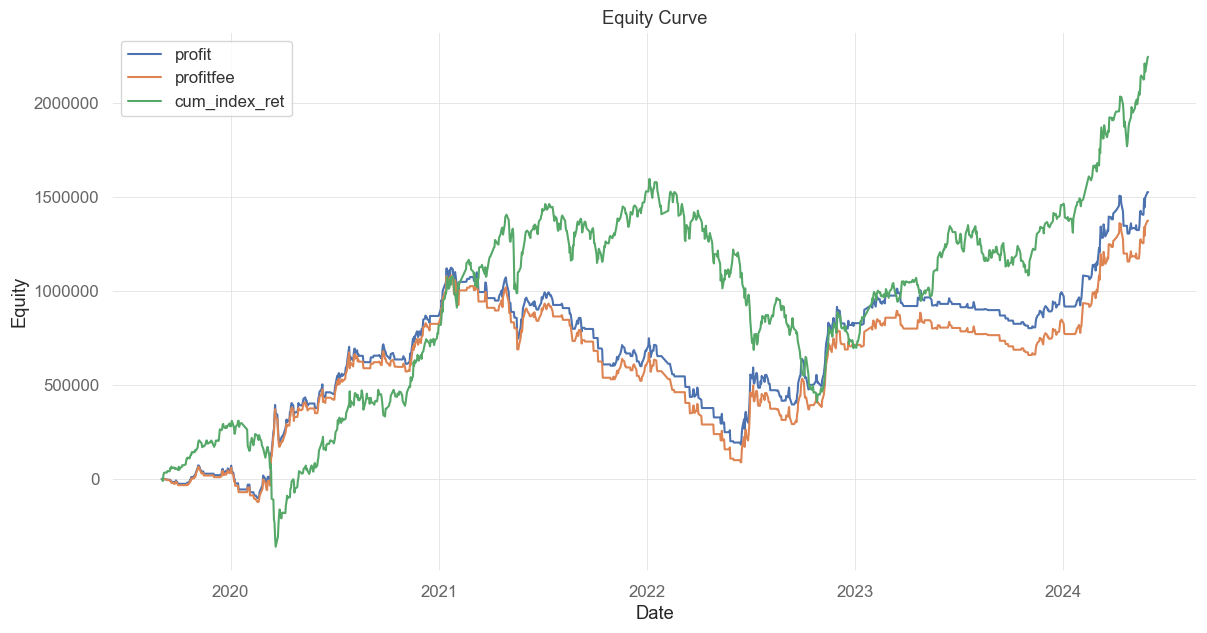

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df.index, df['strategy_ret'], label='profit')
ax.plot(df.index, equity['profitfee'], label='profitfee')
ax.plot(df.index, df['cum_index_ret'], label='cum_index_ret')

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


## 買賣點

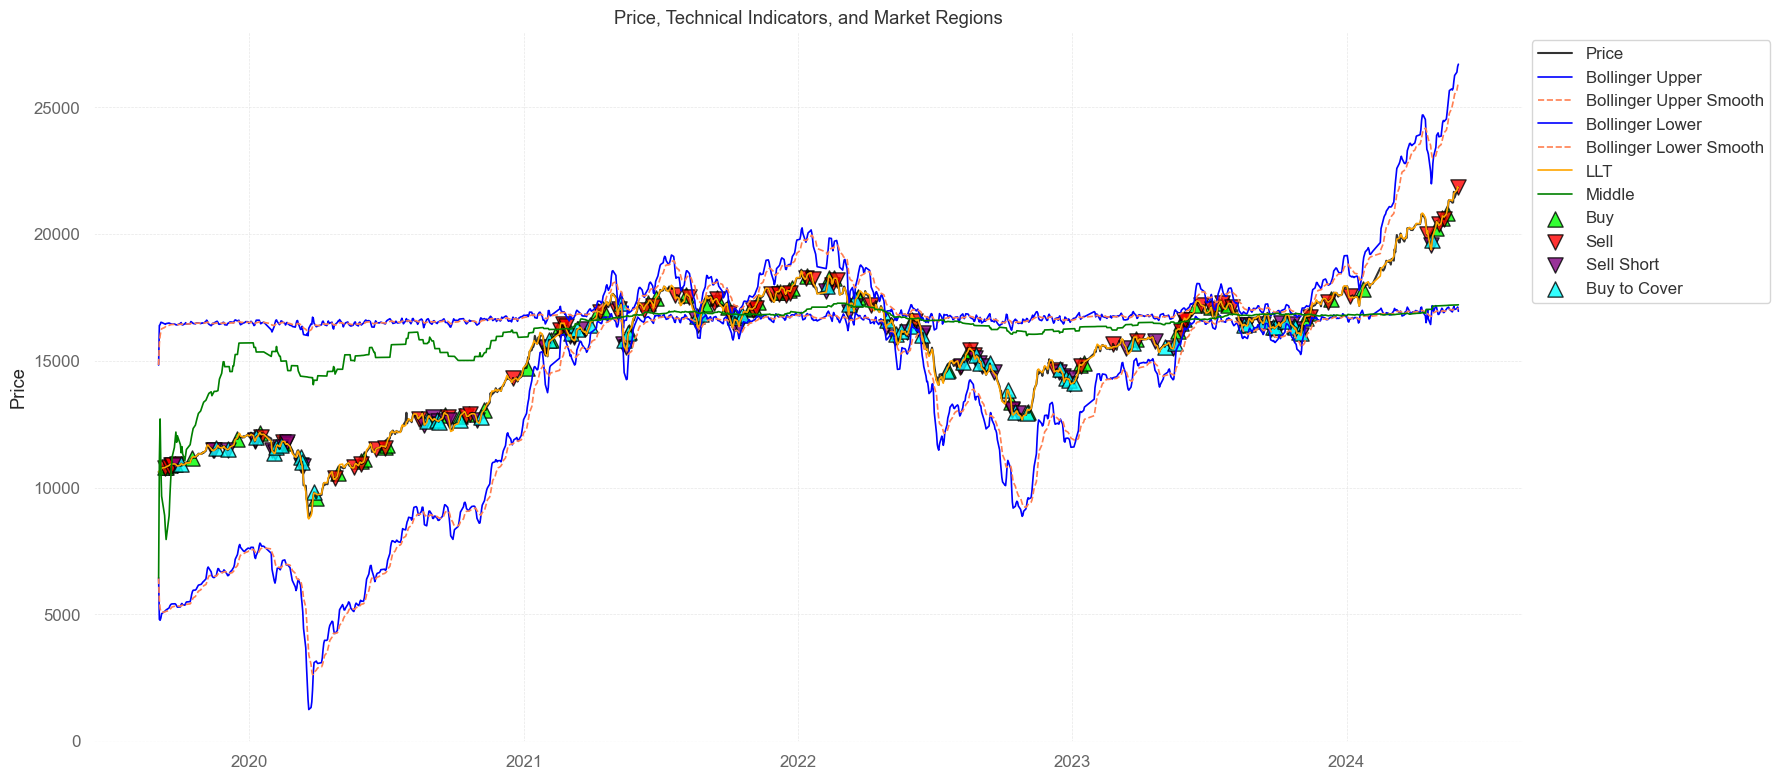

In [ ]:
buy_points = df[df['buy'] > 0]
sell_points = df[df['sell'] > 0]
sellshort_points = df[df['sellshort'] > 0]
buytocover_points = df[df['buytocover'] > 0]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharex=True)

ax1.plot(df.index, df['open'], label='Price', color='black', alpha=0.8, linewidth=1.5)

ax1.plot(df.index, df['bolinger_upper'], label='Bollinger Upper', color='blue', linewidth=1.2)
ax1.plot(df.index, df['bolinger_upper_smooth'], label='Bollinger Upper Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(df.index, df['bolinger_lower'], label='Bollinger Lower', color='blue', linewidth=1.2)
ax1.plot(df.index, df['bolinger_lower_smooth'], label='Bollinger Lower Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(df.index, df['llt'], label='LLT', color='orange', linewidth=1.2)
ax1.plot(df.index, df['middle'], label='Middle', color='green', linewidth=1.2)

ax1.scatter(buy_points.index, df['open'].loc[buy_points.index], color='lime', edgecolor='black', marker='^', label='Buy', s=120, alpha=0.8)
ax1.scatter(sell_points.index, df['open'].loc[sell_points.index], color='red', edgecolor='black', marker='v', label='Sell', s=120, alpha=0.8)
ax1.scatter(sellshort_points.index, df['open'].loc[sellshort_points.index], color='purple', edgecolor='black', marker='v', label='Sell Short', s=120, alpha=0.8)
ax1.scatter(buytocover_points.index, df['open'].loc[buytocover_points.index], color='cyan', edgecolor='black', marker='^', label='Buy to Cover', s=120, alpha=0.8)

## 畫趨勢區域
# bull_region_label_shown = False
# bear_region_label_shown = False
# consolidation_region_label_shown = False
# for i in range(1, len(df)):
#     if df['Bull'].iloc[i]:
#         ax1.axvspan(df.index[i-1], df.index[i], color='lightgreen', alpha=0.5, label='Bull Region' if not bull_region_label_shown else "")
#         bull_region_label_shown = True
#     if df['Bear'].iloc[i]:
#         ax1.axvspan(df.index[i-1], df.index[i], color='lightcoral', alpha=0.5, label='Bear Region' if not bear_region_label_shown else "")
#         bear_region_label_shown = True

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_title('Price, Technical Indicators, and Market Regions')
ax1.set_ylabel('Price')
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## performance

                           Strategy
-------------------------  ----------
Start Period               2019-09-03
End Period                 2024-05-29
Risk-Free Rate             0.0%
Time in Market             58.0%

Cumulative Return          137.47%
CAGR﹪                     13.43%

Sharpe                     0.91
Prob. Sharpe Ratio         97.83%
Smart Sharpe               0.85
Sortino                    1.48
Smart Sortino              1.39
Sortino/√2                 1.05
Smart Sortino/√2           0.98
Omega                      1.24

Max Drawdown               -47.68%
Longest DD Days            1132
Volatility (ann.)          23.86%
Calmar                     0.28
Skew                       1.42
Kurtosis                   14.13

Expected Daily %           0.08%
Expected Monthly %         1.53%
Expected Yearly %          15.51%
Kelly Criterion            10.1%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.39%
Expected Shortfall (cVaR)  -2.39%

Max Consecutive Wins   

/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-01-25,2022-06-14,2024-03-01,1132,-47.68,-46.75
2,2019-11-06,2020-02-17,2020-03-11,127,-17.53,-16.32
3,2020-03-20,2020-03-26,2020-04-16,28,-14.53,-12.81
4,2024-04-10,2024-04-23,2024-05-24,45,-8.65,-7.95
5,2020-09-28,2020-11-03,2020-11-13,47,-6.46,-6.31


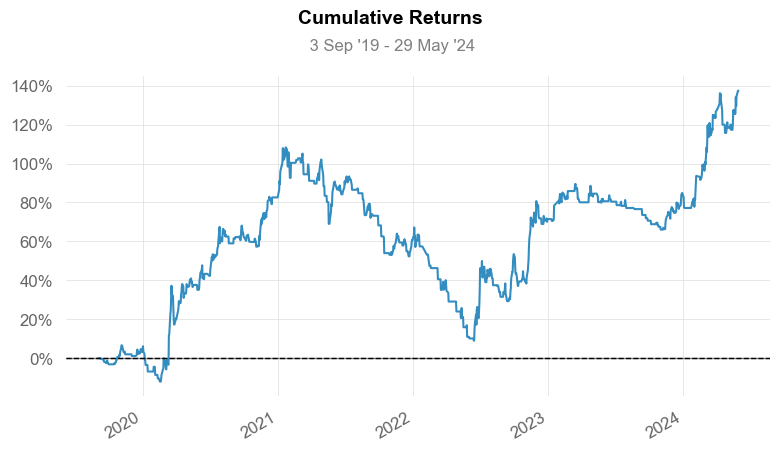

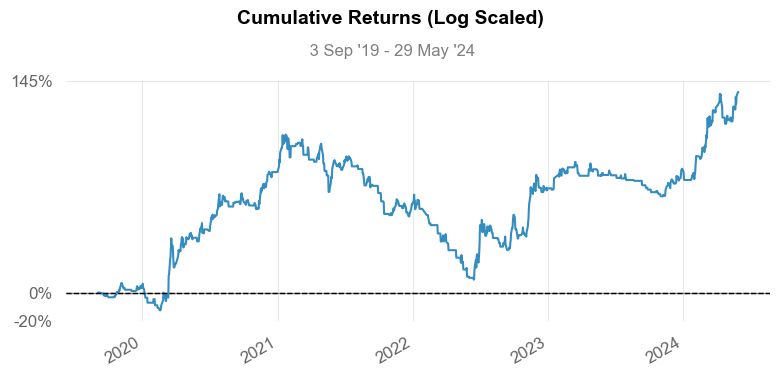

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


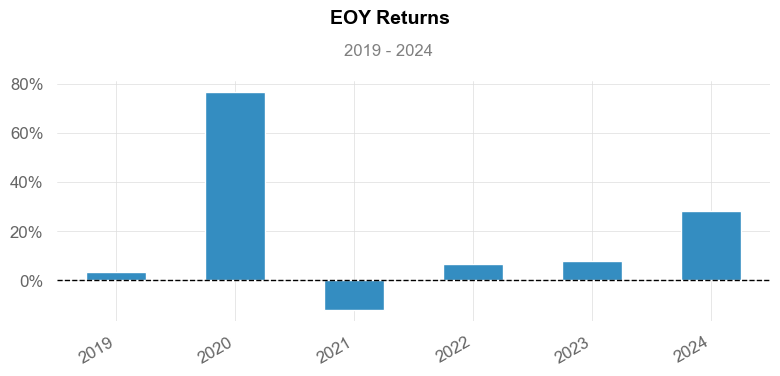

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


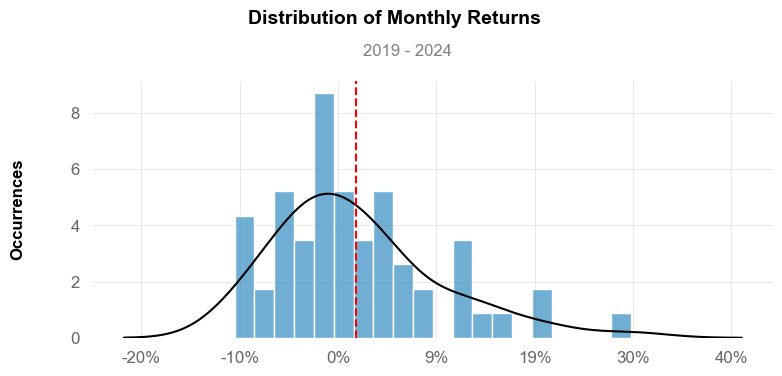

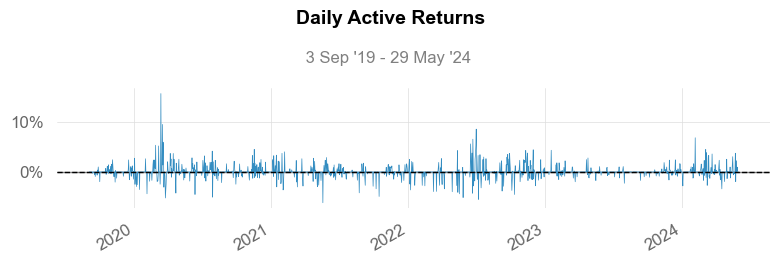

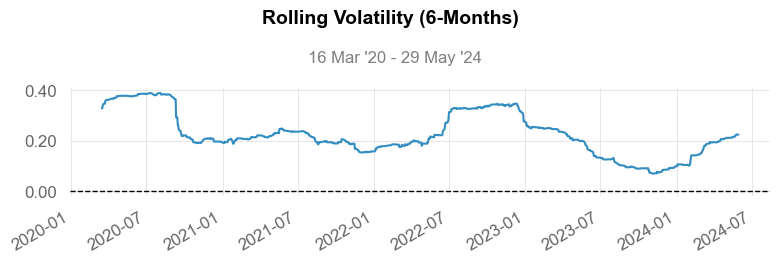

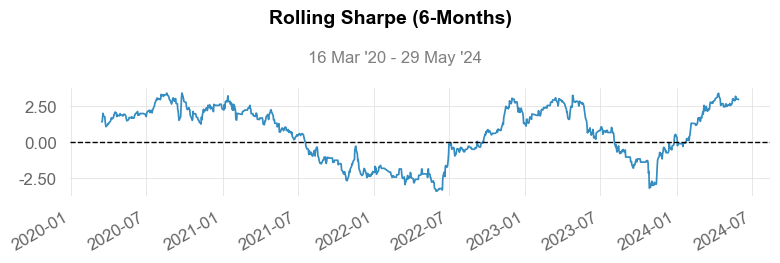

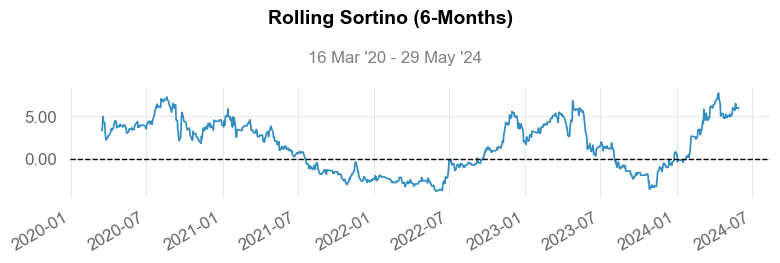

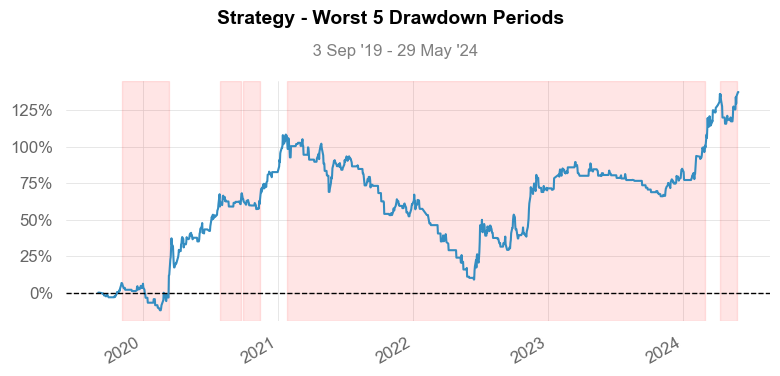

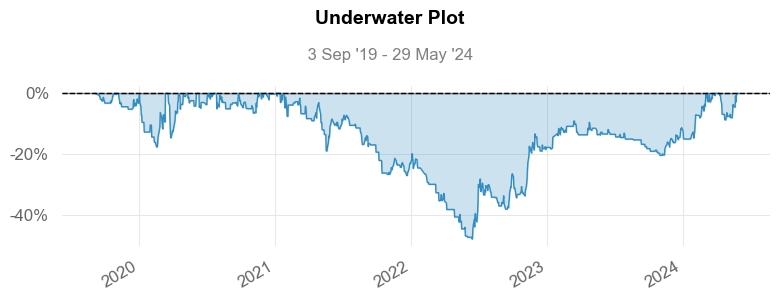

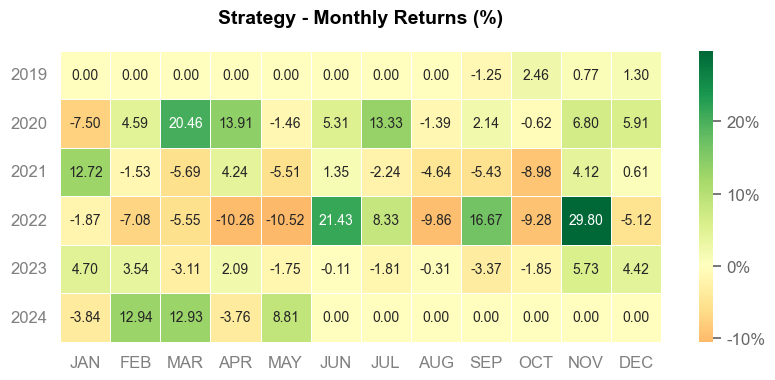

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1019: FutureWarni

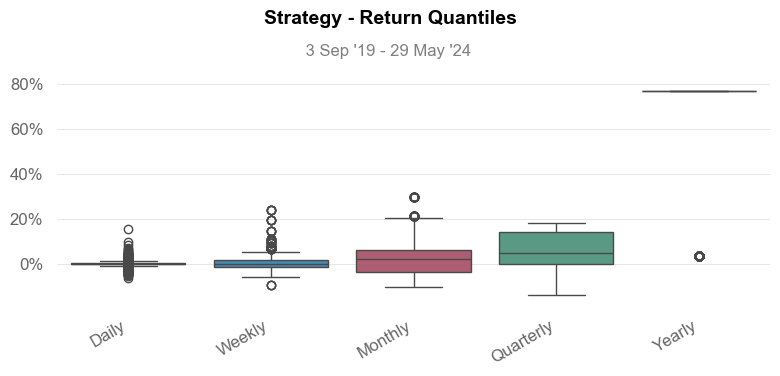

In [ ]:
ret = equity['equity'].pct_change(periods=1).dropna()
quantstats.reports.full(ret)